In [1]:
import os
os.chdir(r'E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\timeseires')

In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from timeseires.utils.to_split import to_split
from timeseires.utils.multivariate_multi_step import multivariate_multi_step
from timeseires.utils.multivariate_single_step import multivariate_single_step
from timeseires.utils.univariate_multi_step import univariate_multi_step
from timeseires.utils.univariate_single_step import univariate_single_step
from timeseires.utils.CosineAnnealingLRS import CosineAnnealingLRS
from timeseires.callbacks.EpochCheckpoint import EpochCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint
from timeseires.callbacks.TrainingMonitor import TrainingMonitor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, Bidirectional, Add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D,TimeDistributed
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,MaxPooling1D,Concatenate,AveragePooling1D, GlobalMaxPooling1D, Input, SimpleRNN
from tensorflow.keras.models import Sequential,Model
import pandas as pd
import time, pickle
import numpy as np
import tensorflow.keras.backend as K
import tensorflow
from tensorflow.keras.layers import Input, Reshape, Lambda
from tensorflow.keras.layers import Layer, Flatten, LeakyReLU, concatenate, Dense
from tensorflow.keras.regularizers import l2
import glob
import h5py
import matplotlib.pyplot as plt
from keras.callbacks import Callback

In [5]:
#lookback = 24
model = None
start_epoch = 0
time_steps=24
num_features=21

In [7]:
def create_rnn():
    input_data = Input(shape=(time_steps, num_features))
    rnn_layer1 = SimpleRNN(8, return_sequences=True)(input_data)
    rnn_layer2 = SimpleRNN(20)(rnn_layer1)
    x = Flatten()(rnn_layer2)
    output_data = Dense(1)(x)
    model = Model(input_data, output_data)
    return model

In [9]:
model1 = create_rnn()
model1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 24, 21)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 24, 8)               │             240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 20)                  │             580 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 841 (3.29 KB)

 Trainable params: 841 (3.29 KB)

 Non-trainable params: 0 (0.00 B)

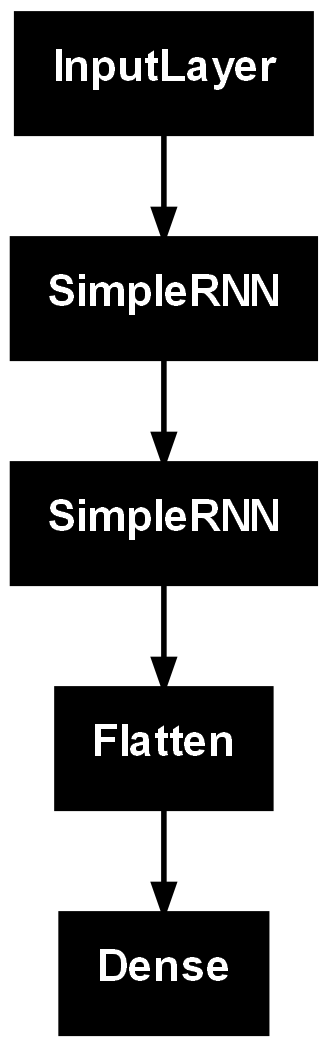

In [11]:
tensorflow.keras.utils.plot_model(model1 )

In [15]:
checkpoints = r'E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 09\\E1-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
OUTPUT_PATH = r'E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 09'
#FIG_PATH = os.path.sep.join([OUTPUT_PATH,"\history.png"])
#JSON_PATH = os.path.sep.join([OUTPUT_PATH,"\history.json"])

In [17]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]

In [19]:
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model =create_rnn()
    opt = Adam(1e-3)
    model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-4)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] compiling model...


In [23]:
import os
path_dataset =r'E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25'
path_tr = os.path.join(path_dataset, 'AEP_train.csv')
df_tr = pd.read_csv(path_tr)
train_set = df_tr.iloc[:].values
path_v = os.path.join(path_dataset, 'AEP_validation.csv')
df_v = pd.read_csv(path_v)
validation_set = df_v.iloc[:].values 
path_te = os.path.join(path_dataset, 'AEP_test.csv')
df_te = pd.read_csv(path_te)
test_set = df_te.iloc[:].values 

path_scaler = os.path.join(path_dataset, 'AEP_Scaler.pkl')
scaler         = pickle.load(open(path_scaler, 'rb'))

train_set.shape, validation_set.shape, test_set.shape

D:\anconda\envs\MLLab\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


((84907, 21), (24259, 21), (12130, 21))

In [25]:
time_steps=24
num_features=21

In [27]:
start = time.time()
train_X , train_y = univariate_multi_step(train_set, time_steps, target_col=0,target_len=1)
validation_X, validation_y = univariate_multi_step(validation_set, time_steps, target_col=0,target_len=1)
test_X, test_y = univariate_multi_step(test_set, time_steps, target_col=0,target_len=1)
print('Time Consumed', time.time()-start, "sec")

Time Consumed 0.7296350002288818 sec


In [29]:
epochs = 30
verbose = 1 #0
batch_size = 32
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,verbose = verbose)

Epoch 1/30
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0802 - mae: 0.0802 - mape: 32.1522
Epoch 1: val_loss improved from inf to 0.01487, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 09\\E1-cp-0001-loss0.01.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - loss: 0.0801 - mae: 0.0801 - mape: 32.1477 - val_loss: 0.0149 - val_mae: 0.0149 - val_mape: 7.9052
Epoch 2/30
2651/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0149 - mae: 0.0149 - mape: 120.0582
Epoch 2: val_loss did not improve from 0.01487
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 0.0149 - mae: 0.0149 - mape: 120.3704 - val_loss: 0.0163 - val_mae: 0.0163 - val_mape: 7.4314
Epoch 3/30
2652/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0130 - mae: 0.0130 - mape: 7.3634
Epoch 3: val_loss improved from 0.01487 to 0.01171, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 09\\E1-cp-0003-loss0.01.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0130 - mae: 0.0130 - mape: 7.7008 - val_loss: 0.0117 - val_mae: 0.0117 - val_mape: 5.4153
Epoch 4/30
2651/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0119 - mae: 0.0119 - mape: 436.3786
Epoch 4: val_loss did not improve from 0.01171
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - loss: 0.0119 - mae: 0.0119 - mape: 436.1417 - val_loss: 0.0121 - val_mae: 0.0121 - val_mape: 6.1235
Epoch 5/30
2649/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0117 - mae: 0.0117 - mape: 419.9557
Epoch 5: val_loss improved from 0.01171 to 0.01136, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 09\\E1-cp-0005-loss0.01.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - loss: 0.0117 - mae: 0.0117 - mape: 419.6625 - val_loss: 0.0114 - val_mae: 0.0114 - val_mape: 4.6041
Epoch 6/30
2651/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0110 - mae: 0.0110 - mape: 409.0469
Epoch 6: val_loss improved from 0.01136 to 0.00957, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 09\\E1-cp-0006-loss0.01.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 0.0110 - mae: 0.0110 - mape: 408.6855 - val_loss: 0.0096 - val_mae: 0.0096 - val_mape: 4.0689
Epoch 7/30
2652/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0105 - mae: 0.0105 - mape: 72.7084
Epoch 7: val_loss did not improve from 0.00957
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.0105 - mae: 0.0105 - mape: 72.7774 - val_loss: 0.0101 - val_mae: 0.0101 - val_mape: 4.1632
Epoch 8/30
2646/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0099 - mae: 0.0099 - mape: 117.1822
Epoch 8: val_loss improved from 0.00957 to 0.00894, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 09\\E1-cp-0008-loss0.01.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0099 - mae: 0.0099 - mape: 117.3408 - val_loss: 0.0089 - val_mae: 0.0089 - val_mape: 4.5649
Epoch 9/30
2651/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0098 - mae: 0.0098 - mape: 261.4548
Epoch 9: val_loss improved from 0.00894 to 0.00878, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 09\\E1-cp-0009-loss0.01.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0098 - mae: 0.0098 - mape: 261.3389 - val_loss: 0.0088 - val_mae: 0.0088 - val_mape: 4.3450
Epoch 10/30
2648/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0093 - mae: 0.0093 - mape: 801.0201
Epoch 10: val_loss did not improve from 0.00878
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 0.0093 - mae: 0.0093 - mape: 799.4576 - val_loss: 0.0104 - val_mae: 0.0104 - val_mape: 5.0101
Epoch 11/30
2650/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0094 - mae: 0.0094 - mape: 214.2610
Epoch 11: val_loss improved from 0.00878 to 0.00872, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 09\\E1-cp-0011-loss0.01.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.0094 - mae: 0.0094 - mape: 214.1993 - val_loss: 0.0087 - val_mae: 0.0087 - val_mape: 3.9174
Epoch 12/30
2646/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0091 - mae: 0.0091 - mape: 340.0229
Epoch 12: val_loss improved from 0.00872 to 0.00797, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 09\\E1-cp-0012-loss0.01.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0091 - mae: 0.0091 - mape: 339.6993 - val_loss: 0.0080 - val_mae: 0.0080 - val_mape: 3.4451
Epoch 13/30
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0091 - mae: 0.0091 - mape: 4.2447
Epoch 13: val_loss did not improve from 0.00797
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.0091 - mae: 0.0091 - mape: 4.2482 - val_loss: 0.0081 - val_mae: 0.0081 - val_mape: 3.4637
Epoch 14/30
2650/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0088 - mae: 0.0088 - mape: 57.0587
Epoch 14: val_loss did not improve from 0.00797
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0088 - mae: 0.0088 - mape: 57.1597 - val_loss: 0.0085 - val_mae: 0.0085 - val_mape: 4.1593
Epoch 15/30
2649/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0088 - mae: 0.0088 - mape: 15.1303
Epoch 15: val_loss did not improve from 0.00797
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0088 - mae: 0.0088 - mape: 15.1261 - val_loss: 0.0080 - val_mae: 0.0

2653/2653 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 0.0086 - mae: 0.0086 - mape: 126.0322 - val_loss: 0.0079 - val_mae: 0.0079 - val_mape: 3.4602
Epoch 17/30
2647/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0086 - mae: 0.0086 - mape: 7.4057
Epoch 17: val_loss improved from 0.00791 to 0.00789, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 09\\E1-cp-0017-loss0.01.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 0.0086 - mae: 0.0086 - mape: 7.4221 - val_loss: 0.0079 - val_mae: 0.0079 - val_mape: 3.3756
Epoch 18/30
2650/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0086 - mae: 0.0086 - mape: 221.0131
Epoch 18: val_loss improved from 0.00789 to 0.00782, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 09\\E1-cp-0018-loss0.01.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - loss: 0.0086 - mae: 0.0086 - mape: 220.7716 - val_loss: 0.0078 - val_mae: 0.0078 - val_mape: 3.5471
Epoch 19/30
2647/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0086 - mae: 0.0086 - mape: 196.4476
Epoch 19: val_loss improved from 0.00782 to 0.00715, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 09\\E1-cp-0019-loss0.01.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 0.0086 - mae: 0.0086 - mape: 196.1734 - val_loss: 0.0071 - val_mae: 0.0071 - val_mape: 3.0975
Epoch 20/30
2649/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0083 - mae: 0.0083 - mape: 113.4570
Epoch 20: val_loss did not improve from 0.00715
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0083 - mae: 0.0083 - mape: 113.3431 - val_loss: 0.0092 - val_mae: 0.0092 - val_mape: 4.0660
Epoch 21/30
2645/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0084 - mae: 0.0084 - mape: 3.0503
Epoch 21: val_loss did not improve from 0.00715
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - loss: 0.0084 - mae: 0.0084 - mape: 3.0513 - val_loss: 0.0090 - val_mae: 0.0090 - val_mape: 4.6466
Epoch 22/30
2647/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0083 - mae: 0.0083 - mape: 29.7962
Epoch 22: val_loss did not improve from 0.00715
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - loss: 0.0083 - mae: 0.0083 - mape: 30.1564 - val_loss: 0.0080 - val_mae:

2653/2653 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 0.0082 - mae: 0.0082 - mape: 15.6948 - val_loss: 0.0069 - val_mae: 0.0069 - val_mape: 3.3303
Epoch 25/30
2648/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0081 - mae: 0.0081 - mape: 12.8059
Epoch 25: val_loss did not improve from 0.00694
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0081 - mae: 0.0081 - mape: 12.8044 - val_loss: 0.0101 - val_mae: 0.0101 - val_mape: 5.3109
Epoch 26/30
2647/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0082 - mae: 0.0082 - mape: 2.6719
Epoch 26: val_loss did not improve from 0.00694
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.0082 - mae: 0.0082 - mape: 2.8191 - val_loss: 0.0072 - val_mae: 0.0072 - val_mape: 3.3750
Epoch 27/30
2643/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0080 - mae: 0.0080 - mape: 61.0494
Epoch 27: val_loss did not improve from 0.00694
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.0080 - mae: 0.0080 - mape: 61.0789 - val_loss: 0.0084 - val_mae: 0.00

In [33]:
model = load_model(r'E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 09\E1-cp-0024-loss0.01.h5',
                   custom_objects={'mae': mean_absolute_error})


y_pred_scaled   = model.predict(test_X)
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled)) 
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

379/379 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Mean Absolute Error (MAE): 108.61
Median Absolute Error (MedAE): 87.41
Mean Squared Error (MSE): 20431.42
Root Mean Squared Error (RMSE): 142.94
Mean Absolute Percentage Error (MAPE): 0.75 %
Median Absolute Percentage Error (MDAPE): 0.6 %


y_test_unscaled.shape=  (12105, 1)
y_pred.shape=  (12105, 1)


In [1]:
checkpoints = r'E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 09\E2-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
model=r'E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 09\E1-cp-0024-loss0.01.h5'
start_epoch= 31

In [17]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
# from sklearn.metrics import mean_absolute_error  # Not needed unless using outside Keras
# from trainingmonitor import TrainingMonitor  # Assuming this is a custom callback

# construct the callbacks
EpochCheckpoint1 = ModelCheckpoint(
    checkpoints,
    monitor="val_loss",
    save_best_only=True, 
    verbose=1
)

TrainingMonitor1 = TrainingMonitor(
    FIG_PATH,
    jsonPath=JSON_PATH,
    startAt=start_epoch
)

# combine callbacks
callbacks = [EpochCheckpoint1, TrainingMonitor1]

# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model = PC.build(time_steps=24, num_features=21, reg=0.0005)
    opt = Adam(1e-3)
    model.compile(
        loss='mae', 
        optimizer=opt, 
        metrics=["mae", "mape"]
    )
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)  # Use custom_objects=... if needed

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-4)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))


In [ ]:
epochs = 10
verbose = 1 #0
batch_size = 32
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,
                        verbose = verbose)

Epoch 1/10
2648/2653 [============================>.] - ETA: 0s - loss: 0.0064 - mae: 0.0064 - mape: 8.6717
Epoch 1: val_loss improved from inf to 0.00682, saving model to C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab9\E2-cp-0001-loss0.01.h5
2653/2653 [==============================] - 31s 11ms/step - loss: 0.0064 - mae: 0.0064 - mape: 8.6602 - val_loss: 0.0068 - val_mae: 0.0068 - val_mape: 3.0920
Epoch 2/10
2651/2653 [============================>.] - ETA: 0s - loss: 0.0064 - mae: 0.0064 - mape: 2.4142
Epoch 2: val_loss improved from 0.00682 to 0.00649, saving model to C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab9\E2-cp-0002-loss0.01.h5
2653/2653 [==============================] - 34s 13ms/step - loss: 0.0064 - mae: 0.0064 - mape: 2.4140 - val_loss: 0.0065 - val_mae: 0.0065 - val_mape: 2.8914
Epoch 3/10
2653/2653 [==============================] - ETA: 0s - loss: 0.0064 - mae: 0.0064 - mape: 8.4092
Epoch 3: val_loss did not improve from 0.00649
2653/26

In [19]:

model = load_model(r'C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab9\E2-cp-0006-loss0.01.h5')

y_pred_scaled   = model.predict(test_X)
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled)) 
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

379/379 [==============================] - 1s 1ms/step
Mean Absolute Error (MAE): 144.75
Median Absolute Error (MedAE): 113.65
Mean Squared Error (MSE): 36189.68
Root Mean Squared Error (RMSE): 190.24
Mean Absolute Percentage Error (MAPE): 0.98 %
Median Absolute Percentage Error (MDAPE): 0.79 %


y_test_unscaled.shape=  (12105, 1)
y_pred.shape=  (12105, 1)
